In [1]:
import rasterio
from rasterio.plot import show
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.ndimage import gaussian_filter
import math
import cv2
import plotly.figure_factory as ff

In [2]:
cmap = 'nipy_spectral'
pi=math.pi

/opt/homebrew/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/cr/d_063phd0572skkv1bwmdz6h0000gn/T/ipykernel_63776/3646042183.py:12: RuntimeWarning: divide by zero encountered in divide
  ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
/var/folders/cr/d_063phd0572skkv1bwmdz6h0000gn/T/ipykernel_63776/3646042183.py:13: RuntimeWarning: divide by zero encountered in divide
  ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))


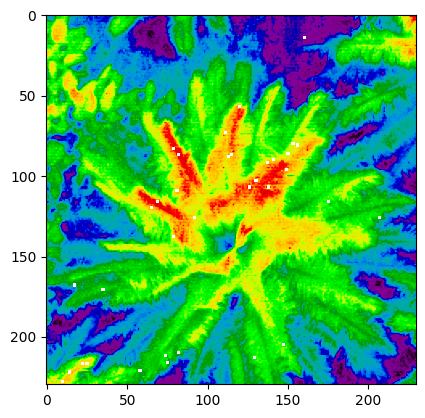

<Axes: >

In [3]:
with rasterio.open('./img/cropped/red.tif') as src:
    red=src.read(1)
with rasterio.open('./img/cropped/nir.tif') as src:
    nir = src.read(1)

with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src:
    nir_field = src.read(1)

with rasterio.open('img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red_field = src.read(1)

ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))
show(ndvi, cmap=cmap)

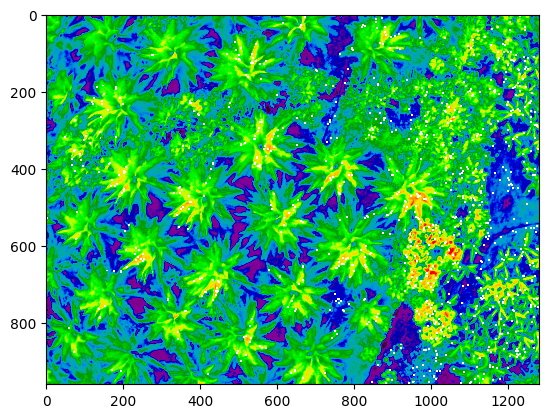

<Axes: >

In [4]:
show(ndvi_field, cmap=cmap)

In [5]:
print(red)

[[14016 12800 11008 ... 13440 13312 13376]
 [13824 11968 12288 ... 14848 14592 15360]
 [12800 13312 12544 ... 19776 19072 17600]
 ...
 [15360 15360 15488 ... 20288 22464 23360]
 [16000 15616 14976 ... 22272 20608 21376]
 [14400 14272 15040 ... 21632 19456 17600]]


In [6]:
red = red/65535.0
nir = nir/65535.0

In [7]:
red_values = [np.mean(red[idx][idx]) for idx in range(len(red))]
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"], bin_size=0.001)
fig.layout.update(showlegend=True, template="simple_white")
fig.layout.update(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.1
fig

I have this two images. This one corresponds to the RED band of a multispectral image: https://ibb.co/mBkjqff, and this one to the NIR one https://ibb.co/8cwsF4N. This images are of an oil palm. I need to find a way to create a gaussian 3D bell, that takes into account the NDVI index to graph it. To be more specific, the gaussian function should be related to the amount of wilt on the palm, which is represented by low NDVI values. 

In [8]:
nir_values = [np.mean(nir[idx][idx]) for idx in range(len(nir))]
fig = ff.create_distplot([nir_values], group_labels=["R"], colors=["purple"], bin_size=0.001)
fig.layout.update(showlegend=True, template="simple_white")
fig.layout.update(title_text="Distribution of nir channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.1
fig

In [9]:
from pytexit import py2tex
py2tex('Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))')


<IPython.core.display.Latex object>

$$\frac{Qm}{2\pi {\sigma_{xy}}^2 \sigma_z} e^{\frac{-\left(xf-x\right)^2}{2{\sigma_{xy}}^2}-\frac{\left(yf-y\right)^2}{2{\sigma_{xy}}^2}-\frac{\left(ndvif-ndvi\right)^2}{2{\sigma_z}^2}}$$


'$$\\frac{Qm}{2\\pi {\\sigma_{xy}}^2 \\sigma_z} e^{\\frac{-\\left(xf-x\\right)^2}{2{\\sigma_{xy}}^2}-\\frac{\\left(yf-y\\right)^2}{2{\\sigma_{xy}}^2}-\\frac{\\left(ndvif-ndvi\\right)^2}{2{\\sigma_z}^2}}$$'

In [10]:
# Definir sigma_xy
def definir_sigma_xy(a,b,x):
    return np.exp(-(1/(a*(x**-b))))

In [11]:
#Definir Amplitud Qm
def definir_amplitud_AQm(sigma_xy):
    return (1/((2*pi)**(3/2)*(sigma_xy**2)))

In [12]:
#Definir patrón de dispersión Qm
def definir_dispersion_Qm(x,y,xf,yf,sigma_xy, AQm):
    return AQm*np.exp(-(xf-x)**2/(2*sigma_xy**2)-(yf-y)**2/(2*sigma_xy**2))


In [13]:
#Definir sigma_xyp
def definir_sigma_xyp(ks, a, b,x):
    return -ks*(1/(a*(x**(-b))))

In [14]:
#Definir amplitud AMCOP
def definir_amplitud_AMCOP(sigma_xyp, Qm):
    return (Qm/((2*pi)**(3/2)*(sigma_xyp**2)))

In [15]:
#Definir Gaussian 3D Function MCOP
def definir_MCOP(AMCOP, x,y, xp, yp, sigma_xyp):
    return AMCOP*np.exp(-(xp-x)**2/(2*sigma_xyp**2)-(yp-y)**2/(2*sigma_xyp**2))

In [16]:
#Variable definition

ks = 0.04 #0.4*10%
a= 1
b = -0.75 #Puede ser -0.25, -0.5, -0.75
x = red.flatten()
y = nir.flatten()
x_field = red_field
y_field = nir_field
xf = 0
yf = 0
xp=0
yp=0


sigma_xy = definir_sigma_xy(a,b,x)
AQm=definir_amplitud_AQm(sigma_xy)
Qm = definir_dispersion_Qm(x,y,xf,yf,sigma_xy,AQm)
sigma_xyp = definir_sigma_xyp(ks, a, b,x)
AMCOP=definir_amplitud_AMCOP(sigma_xyp, Qm)
MCOP=definir_MCOP(AMCOP, x,y, xp,yp, sigma_xyp)

<Axes3D: xlabel='Red', ylabel='NIR', zlabel='NDVI'>

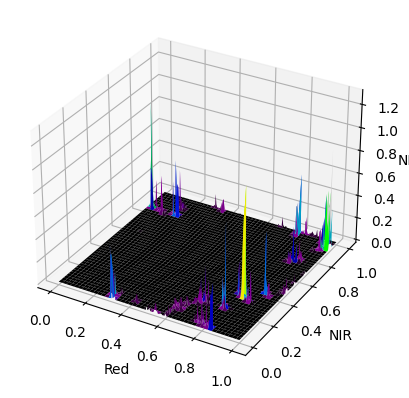

In [17]:
MCOP = MCOP.reshape(red.shape)

# Define the range of values for Red and NIR bands
x = np.linspace(0, 1, red.shape[1])
y = np.linspace(0, 1, red.shape[0])

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Compute Z values using Gaussian function
Z = MCOP

# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cmap)
ax.set_xlabel('Red')
ax.set_ylabel('NIR')
ax.set_zlabel('NDVI')
ax

# ESTE FUNCIONÓ!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

This code generates a 3D plot of a Gaussian bell function based on the NDVI values calculated from the input data (nir and red). The code uses numpy (as np) and matplotlib.pyplot libraries to perform calculations and plot the function, respectively.

The code first calculates the NDVI values using the formula (nir - red) / (nir + red).

Then, it defines the parameters for the Gaussian bell function, such as the center point, the spread in the xy plane (sigma_xy), the spread in the z direction (sigma_z), and the maximum value of the bell function (Qm).

Next, the code creates a meshgrid of x, y, and NDVI values using numpy.meshgrid. The meshgrid allows the code to create a 3D surface plot of the Gaussian bell function.

Then, the code creates the 3D Gaussian bell function using the parameters defined earlier and the NDVI values. The function is defined as f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)), where xf, yf, and ndvif are the meshgrid arrays of x, y, and NDVI values.

Finally, the code plots the 3D Gaussian bell function using matplotlib's plot_surface function and displays the plot using plt.show().

/var/folders/cr/d_063phd0572skkv1bwmdz6h0000gn/T/ipykernel_63776/2934889825.py:27: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



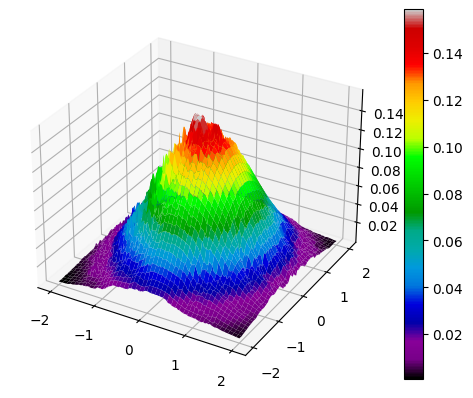

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate the NDVI values
ndvi = (nir - red) / (nir + red)

# Define the parameters for the Gaussian bell function
x = 0  # center point
y = 0  # center point
sigma_xy = 1  # spread in the xy plane
sigma_z = 1  # spread in the z direction
Qm =1  # maximum value of the bell function

# Create a meshgrid for the x, y, and NDVI values
xf, yf = np.meshgrid(np.linspace(-2, 2, red.shape[1]), np.linspace(-2, 2, red.shape[0]))
ndvif = np.meshgrid(np.linspace(-1, 1, red.shape[1]), np.linspace(-1, 1, red.shape[0]))[0]

# Create the 3D Gaussian bell function based on the NDVI values
f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))

# Plot the 3D Gaussian bell function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_array(f)
cbar = plt.colorbar(mappable)
ax.plot_surface(xf, yf, f, cmap=cmap)
plt.show()


In [21]:
print(ndvif)

[[-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]
 [-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]
 [-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]
 ...
 [-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]
 [-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]
 [-1.         -0.99126638 -0.98253275 ...  0.98253275  0.99126638
   1.        ]]


In [19]:
p = np.meshgrid(np.linspace(-1, 1, red.shape[1]), np.linspace(-1, 1, red.shape[0]))

In [20]:
print(p)

[array([[-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ],
       [-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ],
       [-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ],
       ...,
       [-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ],
       [-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ],
       [-1.        , -0.99126638, -0.98253275, ...,  0.98253275,
         0.99126638,  1.        ]]), array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.99126638, -0.99126638, -0.99126638, ..., -0.99126638,
        -0.99126638, -0.99126638],
       [-0.98253275, -0.98253275, -0.98253275, ..., -0.98253275,
        -0.98253275, -0.98253275],
       ...,
       [ 0.98253275,  0.98253275,  0.98253275, ...,  0.98253275,
        

Intento fallido

In [20]:
import numpy as np
import matplotlib.pyplot as plt


# Calculate the NDVI
ndvi = (nir - red) / (nir + red)

# Set up the coordinates for the 3D bell
x, y, z = np.meshgrid(np.linspace(0, 1, ndvi.shape[1]), np.linspace(0, 1, ndvi.shape[0]), np.linspace(0, 1, 20))

# Set the parameters for the 3D bell
sigma_xy = 0.1
sigma_xyp = 0.2
Qm = 1.0
x0 = 0.5
y0 = 0.5

# Calculate the values for the 3D bell
xf = ndvi.flatten()
yf = (1-ndvi).flatten()
xp = np.linspace(0, 1, 100)
yp = np.linspace(0, 1, 100)
z_func1 = (1/((2*np.pi)**(3/2)*(sigma_xy**2)))*np.exp(-(xf-x0)**2/(2*sigma_xy**2)-(yf-y0)**2/(2*sigma_xy**2))
z_func2 = (Qm/((2*np.pi)**(3/2)*(sigma_xyp**2)))*np.exp(-(xp-x0)**2/(2*sigma_xyp**2)-(yp-y0)**2/(2*sigma_xyp**2))
z_func = np.concatenate((z_func1, z_func2))

# Reshape the values for the 3D bell
z = z_func.reshape(ndvi.shape[0], ndvi.shape[1], -1).sum(axis=2)

# Create the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, z, cmap='coolwarm')
ax.set_xlabel('NDVI')
ax.set_ylabel('1-NDVI')
ax.set_zlabel('Wilt')
plt.title('Gaussian 3D Bell')
plt.tight_layout()

# Add the colorbar
mappable = plt.cm.ScalarMappable(cmap='coolwarm')
mappable.set_array(z)
cbar = plt.colorbar(mappable)
cbar.set_label('Wilt')

# Show the plot
plt.show()


ValueError: cannot reshape array of size 53000 into shape (230,230,newaxis)

Intento fallido 2

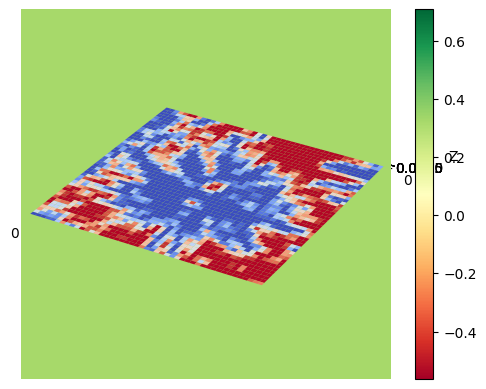

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

red = plt.imread("./img/cropped/red.tif")/255.0
nir= plt.imread("./img/cropped/nir.tif")/255.0

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Set parameters for Gaussian bell
sigma_xy = 5000
sigma_xyp = 5000
Qm = 1000000

x = np.linspace(0, red.shape[1], red.shape[1])
y = np.linspace(0, red.shape[0], red.shape[0])
xf, yf = np.meshgrid(x, y)
xp, yp = np.meshgrid(x, y)

# Calculate Gaussian bell for wilted areas (low NDVI values)
z = np.zeros_like(xf)
z[ndvi < 0.3] = (Qm/((2*np.pi)**(3/2)*(sigma_xyp**2)))*np.exp(-(xp[ndvi < 0.3]-np.mean(x))**2/(2*sigma_xyp**2)-(yp[ndvi < 0.3]-np.mean(y))**2/(2*sigma_xyp**2))

# Calculate Gaussian bell for healthy areas (high NDVI values)
z[ndvi >= 0.3] = (1/((2*np.pi)**(3/2)*(sigma_xy**2)))*np.exp(-(xf[ndvi >= 0.3]-np.mean(x))**2/(2*sigma_xy**2)-(yf[ndvi >= 0.3]-np.mean(y))**2/(2*sigma_xy**2))

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xf, yf, z, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Create colorbar for NDVI values
plt.colorbar(plt.imshow(ndvi, cmap='RdYlGn'))
plt.show()


Intento fallido 3

ValueError: too many values to unpack (expected 2)

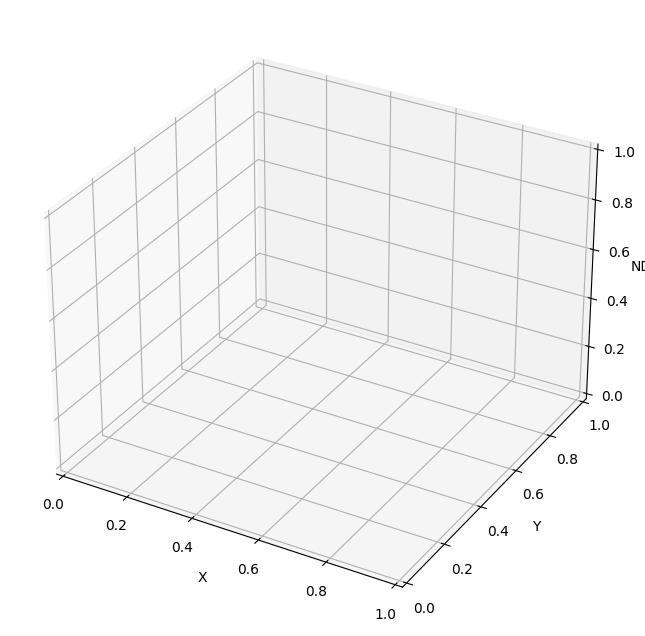

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load the RED and NIR bands
red_band = plt.imread("./img/cropped/red.tif")/255.0
nir_band = plt.imread("./img/cropped/nir.tif")/255.0

# Compute the NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Define the Gaussian function
def gaussian(x, y, z, x0, y0, z0, sigma_xy, sigma_z, Qm, ndvi_threshold):
    if z < ndvi_threshold:
        return 0
    else:
        return ((Qm/((2*np.pi)**(3/2)*(sigma_xy**2)*(sigma_z**2))) *
                np.exp(-(x-x0)**2/(2*sigma_xy**2) -
                       (y-y0)**2/(2*sigma_xy**2) -
                       (z-z0)**2/(2*sigma_z**2)) * z)

# Define the domain for the Gaussian function
x = np.linspace(0, red_band.shape[1], red_band.shape[1])
y = np.linspace(0, red_band.shape[0], red_band.shape[0])
z = np.linspace(0, 1, red_band.shape[0])

# Compute the Gaussian function for each point in the domain
X, Y, Z = np.meshgrid(x, y, z)
gaussian_values = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            gaussian_values[i,j,k] = gaussian(X[i,j,k], Y[i,j,k], Z[i,j,k], 200, 200, 0.5, 50, 0.05, 1, 0.2)

# Plot the Gaussian function as a 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("NDVI")
ax.plot_surface(X, Y, Z[0], cmap="plasma")
plt.show()

# Create a colorbar for the NDVI values
fig = plt.figure(figsize=(2, 8))
ax = fig.add_subplot(111)
im = ax.imshow(ndvi, cmap="plasma")
fig.colorbar(im, ax=ax, shrink=0.5)
ax.axis("off")
plt.show()


------------------

In [ ]:
# Define the compression curve of NDVI
def ndvi_compression(x, a, ks, b):
    return -ks*(1/(a*(x**(-b))))
    #return a*(1 - np.exp(-b*x)) + c*(1 - np.exp(-d*x))


#Define dispersion pattern (Qmxy)
def dispersion_pattern(x, y, mu_x, mu_y, sigma_x, sigma_y, Aq):
    return Aq*np.exp(-(x-mu_x)**2/(2*sigma_x**2)-(y-mu_y)**2/(2*sigma_y**2))


#Calculate Aq
def calculate_amplitude():
    return (1/2)

# Define the range of values for Red and NIR bands
red = red / 65535.0
nir = nir / 65535.0 #Digital resolution 16bits = 65535

The range of pixel values in the red band of a multispectral image depends on the bit-depth of the image, which determines the number of possible values that each pixel can store.

For example, if the image has a bit-depth of 8 bits per pixel, each pixel can store values from 0 to 255, resulting in a total of 256 possible values. If the image has a higher bit-depth, such as 16 bits per pixel, the possible values increase to 65,536.

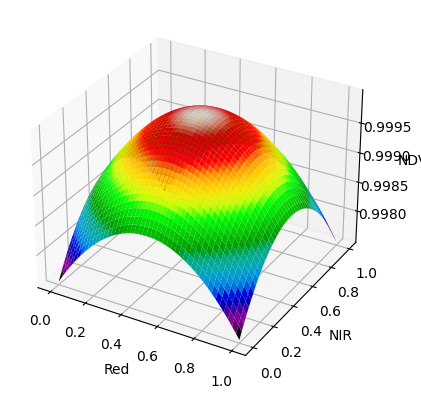

In [25]:

# Define the compression curve of NDVI
def ndvi_compression(x, a, b, c, d):
    return a*(1 - np.exp(-b*x)) + c*(1 - np.exp(-d*x))

# Define the range of values for Red and NIR bands
red = red / 65535.0
nir = nir / 65535.0

# Compute NDVI values using the compression curve
NDVI = ndvi_compression((nir-red)/(nir+red), a=0.1, b=2, c=0.1, d=4)

# Define the range of values for Red and NIR bands
x = np.linspace(0, 1, red.shape[1])
y = np.linspace(0, 1, red.shape[0])

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Define Gaussian function
def gaussian3d(x, y, mu_x, mu_y, sigma_x, sigma_y, A):
    return A*np.exp(-(x-mu_x)**2/(2*sigma_x**2)-(y-mu_y)**2/(2*sigma_y**2))

# Define parameters for Gaussian function
mu_x = 0.5
mu_y = 0.5
sigma_x = 10
sigma_y = 10
A = 1

# Compute Z values using Gaussian function
Z = gaussian3d(X, Y, mu_x, mu_y, sigma_x, sigma_y, A)

# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cmap)
ax.set_xlabel('Red')
ax.set_ylabel('NIR')
ax.set_zlabel('NDVI')
plt.show()



